In [3]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Get the stock data using yahoo API:
style.use('ggplot')

# get 2014-2018 data to train our model
start = datetime.datetime(2014,1,1)
end = datetime.datetime(2018,12,30)
df = web.DataReader("PCG", 'yahoo', start, end) 

# get 2019 data to test our model on 
start = datetime.datetime(2019,1,1)
end = datetime.date.today()
test_df = web.DataReader("PCG", 'yahoo', start, end) 

In [21]:
# sort by date
df = df.sort_values('Date')
test_df = test_df.sort_values('Date')

# fix the date 
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
test_df.reset_index(inplace=True)
test_df.set_index("Date", inplace=True)

df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-12-24,23.60,22.299999,22.35,23.150000,6053900.0,23.150000
2018-12-26,23.35,21.879999,23.18,23.330000,6862000.0,23.330000
2018-12-27,23.60,22.600000,23.18,23.600000,7313600.0,23.600000
2018-12-28,24.43,23.250000,23.58,23.889999,7882600.0,23.889999
2018-12-31,24.23,23.150000,23.23,23.750000,7780200.0,23.750000


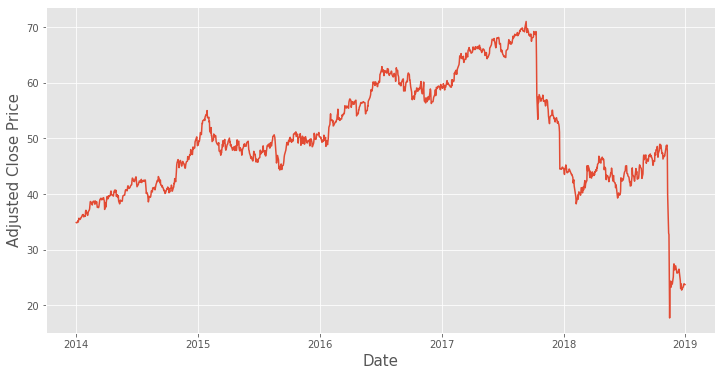

In [22]:
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(df["Adj Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.show()

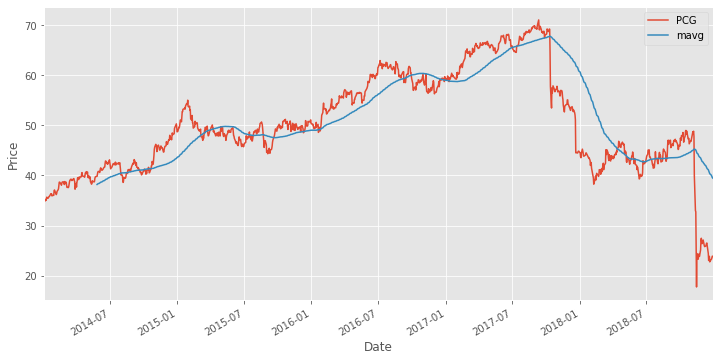

In [23]:
# Rolling mean
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='PCG')
mavg.plot(label='mavg')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

In [24]:
import matplotlib.dates as mdates

# change the dates into ints for training 
dates_df = df.copy()
dates_df = dates_df.reset_index()

# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']

# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
1253,737052.0,23.60,22.299999,22.35,23.150000,6053900.0,23.150000
1254,737054.0,23.35,21.879999,23.18,23.330000,6862000.0,23.330000
1255,737055.0,23.60,22.600000,23.18,23.600000,7313600.0,23.600000
1256,737056.0,24.43,23.250000,23.58,23.889999,7882600.0,23.889999
1257,737059.0,24.23,23.150000,23.23,23.750000,7780200.0,23.750000


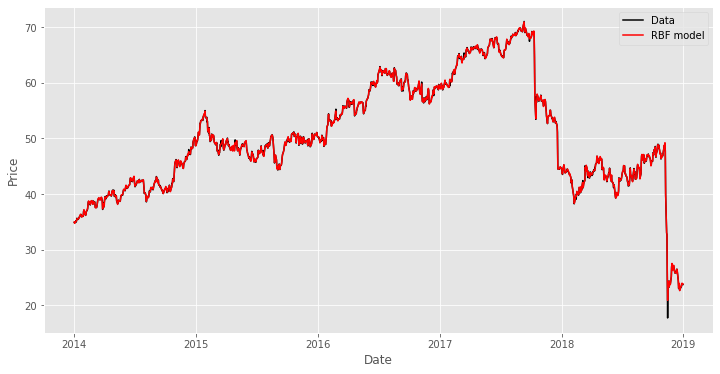

In [25]:
# Use sklearn support vector regression to predicit our data:
from sklearn.svm import SVR

dates = dates_df['Date'].as_matrix()
prices = df['Adj Close'].as_matrix()

#Convert to 1d Vector
dates = np.reshape(dates, (len(dates), 1))
prices = np.reshape(prices, (len(prices), 1))

svr_rbf = SVR(kernel= 'rbf', C= 1e3, gamma= 0.1)
svr_rbf.fit(dates, prices)

plt.figure(figsize = (12,6))
plt.plot(dates, prices, color= 'black', label= 'Data')
plt.plot(org_dates, svr_rbf.predict(dates), color= 'red', label= 'RBF model') 
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [26]:
# Create train set of adj close prices data:
train_data = df.loc[:,'Adj Close'].as_matrix()
print(train_data.shape) # 1258 

(1258,)


In [27]:
# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)

In [28]:
'''Function to create a dataset to feed into an LSTM'''
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [29]:
# Create the data to train our model on:
time_steps = 36
X_train, y_train = create_dataset(train_data, time_steps)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)

(1222, 36, 1)


In [26]:
# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

X_train:
[[150.1000061 ]
 [149.55999756]
 [147.        ]
 [149.36000061]
 [151.27999878]
 [147.52999878]
 [145.72000122]
 [139.33999634]
 [161.27000427]
 [164.13000488]
 [170.97000122]
 [170.00999451]
 [176.67999268]
 [178.55999756]
 [181.5       ]
 [174.6000061 ]
 [169.61999512]
 [178.38000488]
 [175.22999573]
 [182.83999634]
 [181.41000366]
 [177.11000061]
 [178.72999573]
 [174.41999817]
 [178.38000488]
 [186.52999878]
 [196.55999756]
 [196.61999512]
 [195.32000732]
 [199.63000488]
 [198.22999573]
 [203.69999695]
 [193.63999939]
 [209.97000122]
 [209.6000061 ]
 [217.6499939 ]]


y_train: [[248.]]



In [ ]:
# Build the model 
model = keras.Sequential()

model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 100))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(units = 1))

# Compiling the model
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the model to the Training set
history = model.fit(X_train, y_train, epochs = 20, batch_size = 10, validation_split=.30)

Train on 855 samples, validate on 367 samples
Epoch 1/20
855/855 [==============================] - 26s 31ms/step - loss: 0.0206 - val_loss: 0.0049
Epoch 2/20
855/855 [==============================] - 22s 25ms/step - loss: 0.0027 - val_loss: 0.0035
Epoch 3/20
855/855 [==============================] - 21s 24ms/step - loss: 0.0026 - val_loss: 0.0051
Epoch 4/20
855/855 [==============================] - 21s 25ms/step - loss: 0.0026 - val_loss: 0.0046
Epoch 5/20
170/855 [====>.........................] - ETA: 15s - loss: 0.0030

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Get the stock prices for 2019 to have our model make the predictions
test_data = test_df['Adj Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)

In [ ]:
plt.plot(org_y, color = 'red', label = 'Real PG&E Stock Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted PG&E Stock Price')
plt.title('PG&E Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('PG&E Stock Price')
plt.legend()
plt.show()